In [1]:
import gymnasium as gym
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from tqdm import tqdm
import wandb

In [2]:
from dyna import DynaAgent, plot_delta_Q, plot_max_Q

In [3]:
# Parameters
seed = 42
discr_step = [0.05, 0.005]
k = 128
alpha = 0.0
decay = 0.99
discount = 0.99
replay_size = 10_000
start_epsilon=0.9
n_episodes = 15_000

In [4]:
env = gym.make('MountainCar-v0')
env.action_space.seed(seed)

observation, info = env.reset(seed=seed)
# Create the DynaAgent
agent = DynaAgent(decay=decay, start_epsilon=start_epsilon, gamma=discount, discr_step=discr_step, k=k,alpha=alpha, replay_size=replay_size,env=env)

In [5]:

born_inf=env.observation_space.low
born_sup=env.observation_space.high
discr_step = discr_step
n_states = ((born_sup - born_inf) / discr_step).astype(int)+1
born_inf, born_sup, discr_step, n_states

(array([-1.2 , -0.07], dtype=float32),
 array([0.6 , 0.07], dtype=float32),
 [0.05, 0.005],
 array([37, 29]))

In [6]:
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
with tqdm(total=n_episodes, desc=f"Episode 0/{n_episodes}") as pbar:
    finished = 0
    empty = True
    cumulative_env_reward = 0
    for episode in tqdm(range(n_episodes)):
        state, info = env.reset()
        done = False
        # play one episode
        t = 0
        episode_env_reward = 0
        episode_loss = 0
        
        while not done:
            action = agent.select_action(state, env)
            next_state, reward, terminated, truncated, _ = env.step(action)

            loss = agent.update(state, action, reward, next_state)
            done = terminated or truncated
            state = next_state
            if loss is not None:
                episode_env_reward += reward
                episode_loss+=loss           
            t+=1

        agent.decay_epsilon()

        pbar.set_description(f"Episode {episode + 1}/{n_episodes}")
        pbar.set_postfix(train_loss=episode_loss, epsilon=agent.epsilon, episode_steps=t, episode_env_reward=episode_env_reward, finished=finished, cumulative_env_reward=cumulative_env_reward)
        pbar.update(1)
        pbar.refresh() 
        if not empty:
            finished += terminated
            cumulative_env_reward += episode_env_reward

            agent.decay_epsilon()
            # wandb.log({"train_loss": episode_loss, "epsilon": agent.epsilon, "episode_steps": t, "finished": finished, "episode_env_reward":episode_env_reward, "episode_aux_reward":episode_auxiliary_reward, "cumulative_env_reward":cumulative_env_reward, "cumulative_aux_reward":cumulative_auxiliary_reward})
        if loss is not None:
            empty = False

Episode 0/15000:   0%|          | 0/15000 [00:00<?, ?it/s]

Episode 6085/15000:  41%|████      | 6085/15000 [23:21<34:14,  4.34it/s, cumulative_env_reward=-1.21e+6, episode_env_reward=-200, episode_steps=200, epsilon=0.05, finished=0, train_loss=-0.00107]


KeyboardInterrupt: 

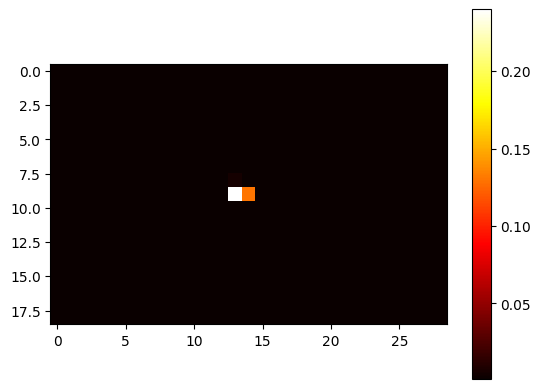

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Create a 10x10 numpy array
data = agent.P_hat[agent.n_states[0]//2,agent.n_states[1]//2,0,:,:]/np.sum(agent.P_hat[agent.n_states[0]//2,agent.n_states[1]//2,0,:,:])

# Create a heatmap using matplotlib
plt.imshow(data, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

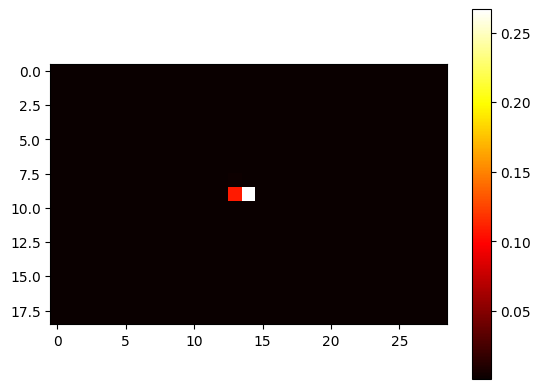

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Create a 10x10 numpy array
data = agent.P_hat[agent.n_states[0]//2,agent.n_states[1]//2,1,:,:]/np.sum(agent.P_hat[agent.n_states[0]//2,agent.n_states[1]//2,1,:,:])

# Create a heatmap using matplotlib
plt.imshow(data, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

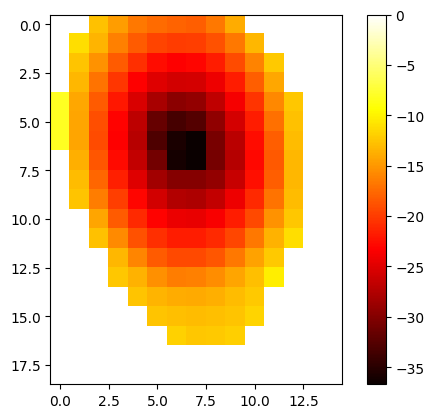

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Create a 10x10 numpy array
data = agent.Q[:,:,0]

# Create a heatmap using matplotlib
plt.imshow(data, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

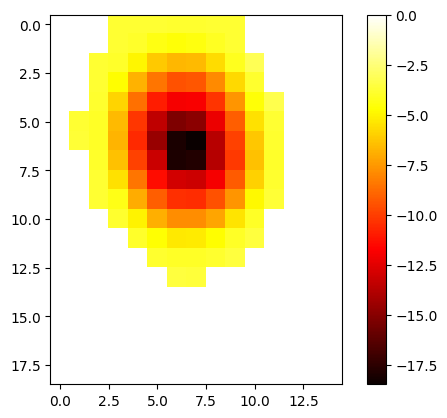

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Create a 10x10 numpy array
data = agent.Q[:,:,0]

# Create a heatmap using matplotlib
plt.imshow(data, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

In [12]:
np.array([[],[]])[0]

array([], dtype=float64)

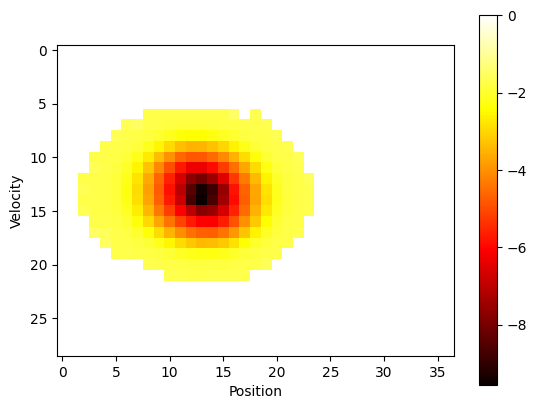

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Create a 10x10 numpy array
data = agent.Q[:,:,0].T

# Create a heatmap using matplotlib
plt.imshow(data, cmap='hot', interpolation='nearest')
plt.xlabel('Position')
plt.ylabel('Velocity')
plt.colorbar()
plt.show()

In [ ]:
logging_steps = 1000
# Create the environment
env = gym.make('MountainCar-v0')
# Create the DynaAgent
dyna_agent = DynaAgent(decay=0.999, discr_step=[0.025, 0.005], k=64,alpha=0.0,env=env)

# Train the agent
n_episodes = 10_000
episode_rewards=[]
episode_durations = []
trajectories = []

fig,ax=plt.subplots(1,2,figsize=(11,5))
finished = 0
with tqdm(total=n_episodes, desc=f"Episode 0/{n_episodes}") as pbar:

    for episode in tqdm(range(n_episodes)):
        state,_ = env.reset()
        total_reward = 0
        done = False
        x=[state[0]]
        v=[state[1]]
        n_itr=0
        while not done:
            action = dyna_agent.select_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)

            dyna_agent.update(state, action, reward, next_state)
            done= terminated or truncated
            state = next_state
            total_reward += reward
            n_itr+=1
            x.append(state[0])  
            v.append(state[1])

        dyna_agent.decay_epsilon()
        
        episode_rewards.append(total_reward) 
        episode_durations.append(n_itr)
        
        if (episode%logging_steps==0):
            color = f"{0.9*(1-(episode+1)/n_episodes)}"
            ax[0].plot(list(range(n_itr+1)),x, label=f'episode {episode}',c=color, zorder = 1)
            ax[1].plot(list(range(n_itr+1)),v, label=f'episode {episode}',c=color, zorder = 1)
        finished+=int(terminated)
        pbar.set_description(f"Episode {episode + 1}/{n_episodes}")
        pbar.set_postfix(finished=finished, epsilon=dyna_agent.epsilon, n_itr=n_itr)
        pbar.update(1)
        pbar.refresh() 
env.close()
ax[0].set_xlabel('Episodes')
ax[0].set_ylabel('Position')dyna_agent
plt.show()



plt.plot(episode_durations, label='episode durations')
plt.plot(episode_rewards,label='episode rewards')
plt.title('Duration and total reward for each episode' )
plt.xlabel('Episodes')
plt.legend()
